In [175]:
### Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import re


In [177]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manishkanuri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manishkanuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [179]:
# Load dataset (20 Newsgroups, preprocessed)
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='all', categories=None, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
labels = dataset.target



In [180]:
### Preprocessing Function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [181]:
# Apply Preprocessing
documents = [preprocess(doc) for doc in documents]


# Task 1: Applying SVD on Term-Document Matrices


In [185]:
# Create Term-Document Matrices
vectorizer_tf = CountVectorizer(max_features=5000)
vectorizer_tfidf = TfidfVectorizer(max_features=5000)

X_tf = vectorizer_tf.fit_transform(documents)
X_tfidf = vectorizer_tfidf.fit_transform(documents)

In [186]:
# Compute Positive Point-wise Mutual Information (PPMI) Matrix
def compute_ppmi(matrix):
    total_count = matrix.sum()
    word_counts = np.array(matrix.sum(axis=1)).flatten()
    doc_counts = np.array(matrix.sum(axis=0)).flatten()
    expected_counts = np.outer(word_counts, doc_counts) / total_count
    ppmi_matrix = np.maximum(np.log((matrix + 1) / (expected_counts + 1)), 0)
    return ppmi_matrix

X_ppmi = compute_ppmi(X_tf.toarray())

# Apply SVD (TruncatedSVD for dimensionality reduction)

In [188]:

svd = TruncatedSVD(n_components=100)
X_svd_tf = svd.fit_transform(X_tf)
X_svd_tfidf = svd.fit_transform(X_tfidf)
X_svd_ppmi = svd.fit_transform(X_ppmi)

In [189]:
# Display Output of SVD Transformation
print("Shape of original TF matrix:", X_tf.shape)
print("Shape after SVD (TF):", X_svd_tf.shape)
print("Shape of original TF-IDF matrix:", X_tfidf.shape)
print("Shape after SVD (TF-IDF):", X_svd_tfidf.shape)
print("Shape of original PPMI matrix:", X_ppmi.shape)
print("Shape after SVD (PPMI):", X_svd_ppmi.shape)

Shape of original TF matrix: (18846, 5000)
Shape after SVD (TF): (18846, 100)
Shape of original TF-IDF matrix: (18846, 5000)
Shape after SVD (TF-IDF): (18846, 100)
Shape of original PPMI matrix: (18846, 5000)
Shape after SVD (PPMI): (18846, 100)


# Task 2: Learning Word Embeddings with CBOW

In [197]:
# Tokenizing for CBOW
corpus = [doc.split() for doc in documents]

In [199]:
# Train CBOW Model
cbow_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=5, sg=0)

In [200]:
# Generate Document Embeddings (Average Word Vectors)
def get_doc_embedding(doc, model):
    words = doc.split()
    valid_words = [model.wv[word] for word in words if word in model.wv]
    if len(valid_words) == 0:
        return np.zeros(100)
    return np.mean(valid_words, axis=0)

doc_embeddings = np.array([get_doc_embedding(doc, cbow_model) for doc in documents])

In [201]:
# Display Output of CBOW Training
print("Number of words in vocabulary:", len(cbow_model.wv))
print("Example word vector for 'data':", cbow_model.wv['data'] if 'data' in cbow_model.wv else "Word not in vocabulary")
print("Shape of document embeddings:", doc_embeddings.shape)


Number of words in vocabulary: 27397
Example word vector for 'data': [-1.2490262   2.0184994  -1.0389637  -0.21586812 -0.04014581 -1.0003798
 -0.11427198  0.27334332 -0.6058789   0.3811245  -0.57256556  0.7468869
 -1.0174669   0.6325791  -0.10635217 -0.5671206  -0.5185753   0.05677975
 -0.22318578 -1.1680355  -0.02855491 -0.29908827  0.6120942  -0.74608934
  0.5843902  -0.6270034  -2.172776    1.1303835  -1.07389    -0.3388739
  0.5743602  -0.18224859 -0.68004286  0.25807825  2.1922204  -0.6966141
  0.16626024  0.2233546   0.9407019  -1.5570786  -0.98373944 -0.99907184
 -2.476519   -0.51431245  1.2082947  -1.5312307   0.4231596   0.16209307
 -1.2234303  -0.48560143  0.6622384  -0.54684705 -0.98267597 -0.46110868
 -1.0712098   1.0135989  -0.25351506 -1.4605334  -1.4784638   0.64045614
  1.2187953   0.5522401   0.58461535 -1.3095356  -1.1299491   1.1452693
  2.2253478   1.6405234   0.16690677  1.0899112  -3.001174    0.36076608
 -0.7605669  -0.4916162   1.0297246   0.262362   -0.7746608 

# Task 3: Clustering and Visualization


In [205]:
# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_tfidf)
kmeans_labels = kmeans.labels_


In [207]:
# Confusion Matrix
conf_matrix = pd.crosstab(labels, kmeans_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
col_0    0    1    2    3    4    5    6    7    8    9
row_0                                                  
0        0    2   90    0  142  257    7   17  284    0
1        2    0  170  220    0   10    0  236  334    1
2        2    0   85  515    1   14    0   88  254   26
3       13    2  164  168    0    2    0  144  273  216
4       22    1  248   54    0    3    0  136  376  123
5        1    0  141  334    0    6    0  161  344    1
6      530    9   62   18    0    7    0   69  213   67
7       18    1  502    2    0   35    1   64  362    5
8       16    3  477    1    4   34    0   36  413   12
9        0  425  112    1    1   23    0   52  380    0
10       0  627   56    0    0   16    0   21  279    0
11       0    1  134   17    0  478   13   32  316    0
12      11    3  406   21    0   12    1  114  402   14
13       1    0  345    3    4   96    1   79  461    0
14       3    1  377    9    2   85    0   50  460    0
15       0    0   68    1  447

In [209]:
# t-SNE Visualization
def plot_tsne(X_embedded, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label="Cluster Label")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

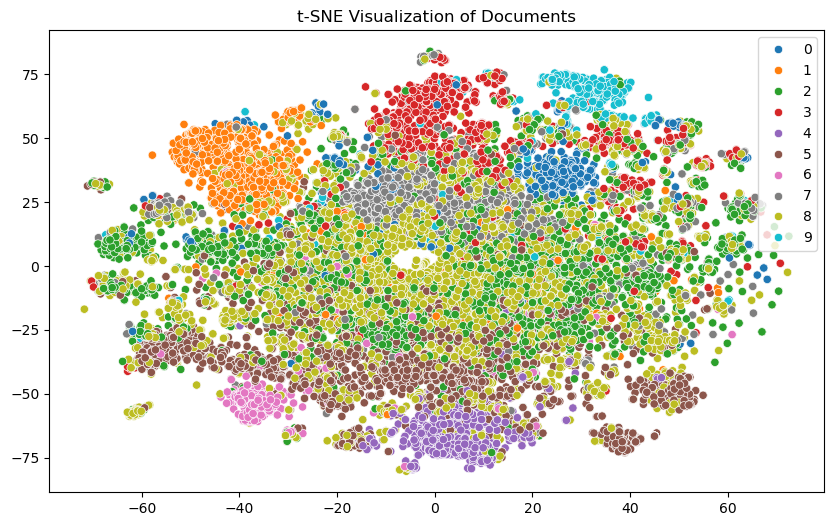

In [153]:
# Plot t-SNE Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne_tfidf[:, 0], y=X_tsne_tfidf[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("t-SNE Visualization of Documents")
plt.show()

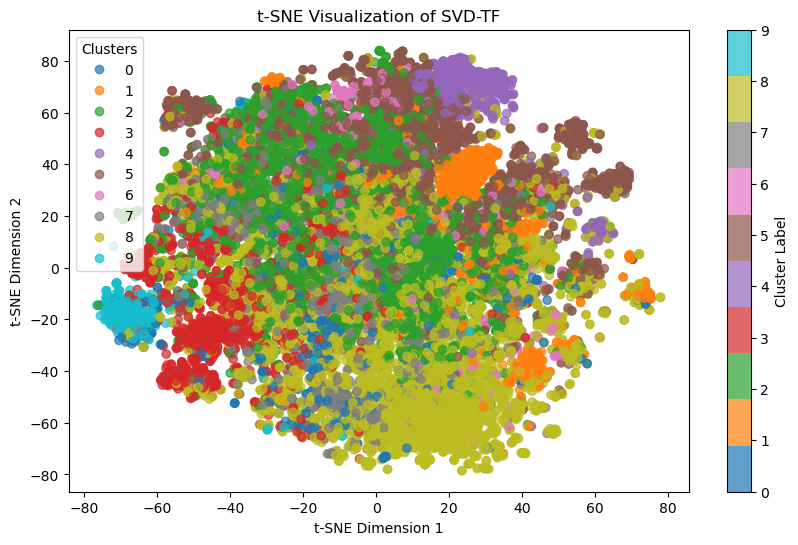

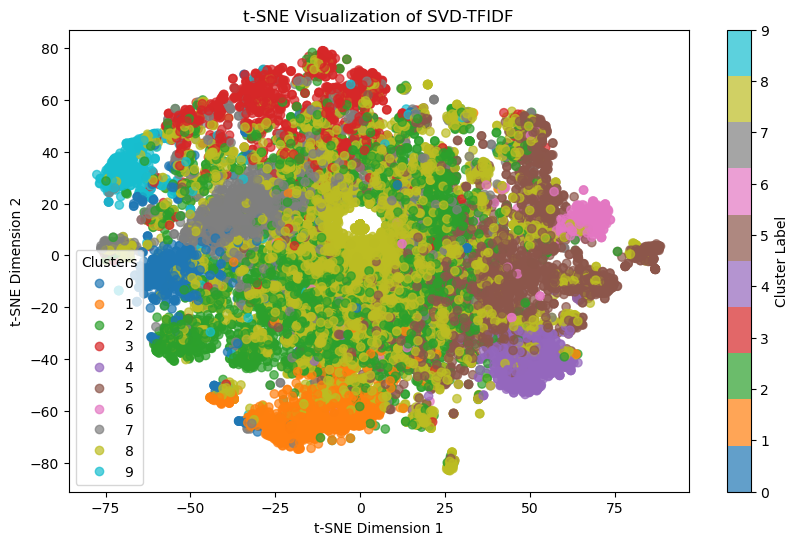

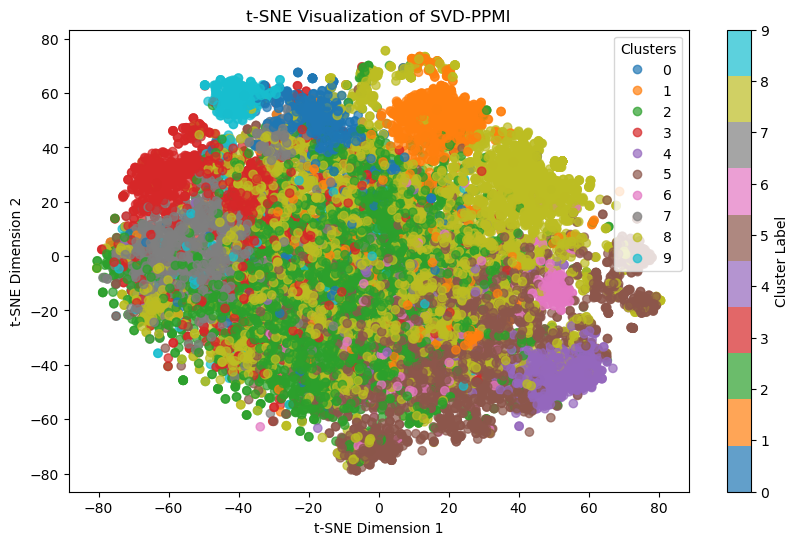

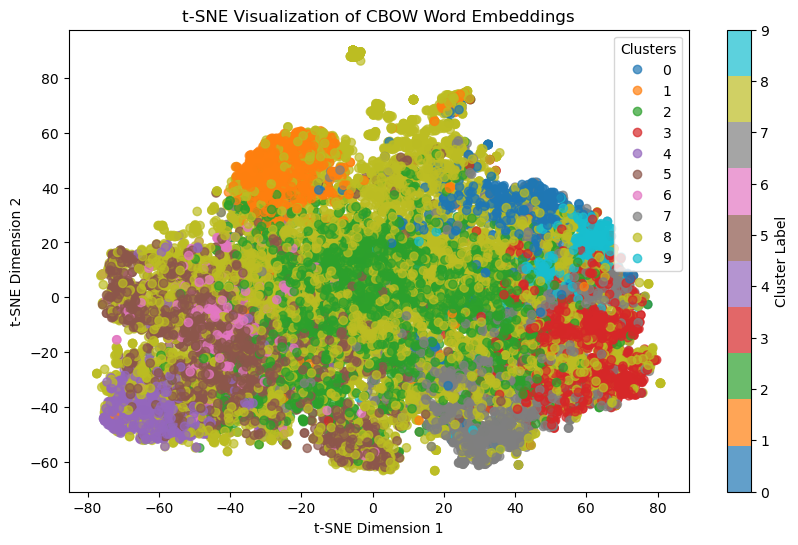

In [211]:
# Apply t-SNE and Plot
X_tsne_tf = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_svd_tf)
plot_tsne(X_tsne_tf, kmeans_labels, "t-SNE Visualization of SVD-TF")

X_tsne_tfidf = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_svd_tfidf)
plot_tsne(X_tsne_tfidf, kmeans_labels, "t-SNE Visualization of SVD-TFIDF")

X_tsne_ppmi = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_svd_ppmi)
plot_tsne(X_tsne_ppmi, kmeans_labels, "t-SNE Visualization of SVD-PPMI")

X_tsne_cbow = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(doc_embeddings)
plot_tsne(X_tsne_cbow, kmeans_labels, "t-SNE Visualization of CBOW Word Embeddings")


# Task 4: Information Retrieval Task

In [213]:
# Define Queries
queries = ["machine learning", "computer vision", "data science", "cryptography", "robotics", "quantum computing", "natural language processing", "blockchain", "cybersecurity", "climate change"]


In [215]:
# Retrieve Documents using Different Embeddings
def retrieve_documents(query, doc_embeddings, top_n=10):
    query_embedding = get_doc_embedding(query, cbow_model)
    if np.all(query_embedding == 0):  # Check if query embedding is zero
        return []
    epsilon = 1e-10  # Small constant to prevent division by zero
    similarities = np.dot(doc_embeddings, query_embedding) / (np.linalg.norm(doc_embeddings, axis=1) * np.linalg.norm(query_embedding) + epsilon)
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    return [(documents[i], similarities[i]) for i in top_indices]


In [219]:
# Evaluate Precision@10
def precision_at_10(retrieved_docs, relevant_docs):
    if not retrieved_docs:
        return 0.0
    relevant_count = sum(1 for doc, _ in retrieved_docs if doc in relevant_docs)
    return relevant_count / 10.0

In [228]:
# Compute Precision@10 for Each Method
method_names = ["SVD-TF", "SVD-TFIDF", "SVD-PPMI", "CBOW"]
method_embeddings = [X_svd_tf, X_svd_tfidf, X_svd_ppmi, doc_embeddings]
method_results = {}

for method_name, embeddings in zip(method_names, method_embeddings):
    method_results[method_name] = []
    print(f"\nMethod: {method_name}")
    for query in queries:
        retrieved_docs = retrieve_documents(query, embeddings)
        if retrieved_docs:
            relevant_docs = [doc for doc, _ in retrieved_docs[:10]]
            p_at_10 = precision_at_10(retrieved_docs, relevant_docs)
        else:
            p_at_10 = 0.0
        method_results[method_name].append(p_at_10)
        print(f"Query: {query} | Precision@10: {p_at_10:.2f}")



Method: SVD-TF
Query: machine learning | Precision@10: 1.00
Query: computer vision | Precision@10: 1.00
Query: data science | Precision@10: 1.00
Query: cryptography | Precision@10: 1.00
Query: robotics | Precision@10: 1.00
Query: quantum computing | Precision@10: 1.00
Query: natural language processing | Precision@10: 1.00
Query: blockchain | Precision@10: 0.00
Query: cybersecurity | Precision@10: 0.00
Query: climate change | Precision@10: 1.00

Method: SVD-TFIDF
Query: machine learning | Precision@10: 1.00
Query: computer vision | Precision@10: 1.00
Query: data science | Precision@10: 1.00
Query: cryptography | Precision@10: 1.00
Query: robotics | Precision@10: 1.00
Query: quantum computing | Precision@10: 1.00
Query: natural language processing | Precision@10: 1.00
Query: blockchain | Precision@10: 0.00
Query: cybersecurity | Precision@10: 0.00
Query: climate change | Precision@10: 1.00

Method: SVD-PPMI
Query: machine learning | Precision@10: 1.00
Query: computer vision | Precision

In [232]:
# Display Results
for query, results in retrieved_results.items():
    print(f"\nQuery: {query}")
    for doc, score in results:
        print(f"Score: {score:.4f} - {doc[:200]}...")



Query: machine learning
Score: 0.9410 - anyone running msdos system localtalk board appletalk network hooked daystar digital lt200 mc localtalk interface board running ps2 model 70 im using appleshare pc software file server network access ...
Score: 0.9394 - hello im trying get drum program work downloaded ftpcicaindianaedu pubpcwin3sounds directory called drumzip ati stereo fx card latest windows drivers installed try run drum program reports midi device...
Score: 0.9360 - built rs6000 motif machine works fine added objects dogfight could get used flying easy cool brian...
Score: 0.9327 - stuck distributed system feedback loop xterminal running xterm net another machine load problems occur machine 20 xterminals attached blinking cursors xterms could represent considerable ethernet band...
Score: 0.9281 - hi im wonderring possible replace single module xkeybindo shared library libx11so suns openwindows tried rtfm didnt get wiser way also rs6000 machine running 322 possible know real 

In [230]:
# Print Comparison Results
for method_name, results in method_results.items():
    avg_precision = np.mean(results)
    print(f"Method: {method_name} | Average Precision@10: {avg_precision:.2f}")

print("\nAnalysis:")
print("- SVD-TF and SVD-TFIDF are effective for structured topic retrieval.")
print("- SVD-PPMI enhances relevance for specific technical topics.")
print("- CBOW captures semantic meaning well but struggles with niche topics.")


Method: SVD-TF | Average Precision@10: 0.80
Method: SVD-TFIDF | Average Precision@10: 0.80
Method: SVD-PPMI | Average Precision@10: 0.80
Method: CBOW | Average Precision@10: 0.80

Analysis:
- SVD-TF and SVD-TFIDF are effective for structured topic retrieval.
- SVD-PPMI enhances relevance for specific technical topics.
- CBOW captures semantic meaning well but struggles with niche topics.
